In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import pyJHTDB
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse

from mpiFFT4py.slab import R2C

In [3]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

# Computational Domain

nx=Nx//nproc; ny=Ny; nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:5] 
n_proc = 8
rank = 0


In [4]:
%%px 

N = np.array([Nx,Ny,Nz],dtype=int)
L = np.array([Lx,Ly,Lz],dtype=float)

FFT = R2C(N, L, MPI.COMM_WORLD, "double", communication='Alltoallw')

In [5]:
%%px

dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

comm.Barrier(); t1=MPI.Wtime()

X = np.zeros(FFT.real_shape(), dtype=FFT.float)
Y = np.zeros(FFT.real_shape(), dtype=FFT.float)
Z = np.zeros(FFT.real_shape(), dtype=FFT.float)

r2 = np.zeros(FFT.real_shape(), dtype=FFT.float)

chi = np.zeros(FFT.real_shape(), dtype=FFT.float)
cchi = np.zeros(FFT.complex_shape(), dtype=FFT.complex)
corr = np.zeros(FFT.real_shape(), dtype=FFT.float)
iCorr = np.zeros(FFT.real_shape(), dtype=FFT.float)

r2Sum = np.zeros(FFT.real_shape(), dtype=FFT.float)
r2F = np.zeros(FFT.real_shape(), dtype=FFT.float)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocating vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Alocating vectors: 0.00 seconds


In [6]:
%%px

comm.Barrier(); t1=MPI.Wtime()
for i in range(nx):
    X[i,:,:] = (i+rank*nx)*isotropic1024coarse['dx']

for j in range(ny):
    Y[:,j,:] = j*isotropic1024coarse['dy']
    
for k in range(nz):
    Z[:,:,k] = k*isotropic1024coarse['dz']
    
r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

r2rt = np.sqrt(r2)
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing the real domain for radial integration: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Preparing the real domain for radial integration: 602.46 seconds


In [7]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "ref-enstrophy-"+str(rank)+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned(FFT.real_shape(), dtype=FFT.float)
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2'].astype(FFT.float)
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] 
Finished loading
Load from disk: 174.57 seconds


In [8]:
%%px

w2[:,:,:] = 0.5*w2[:,:,:]

In [9]:
%%px

avgOmega = np.average(w2)
avgOmegaGl=np.zeros(1,dtype=FFT.float)

comm.Reduce([avgOmega,MPI.DOUBLE],[avgOmegaGl,MPI.DOUBLE],op=MPI.SUM)
avgOmega = avgOmegaGl[0]/nproc
avgOmega = comm.bcast(avgOmega, root=0)

##########################

minw2 = w2.min()
maxw2 = w2.max()

minwGl=np.zeros(nproc,dtype=FFT.float)
maxwGl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minw2,MPI.DOUBLE],[minwGl,MPI.DOUBLE])
comm.Allgather([maxw2,MPI.DOUBLE],[maxwGl,MPI.DOUBLE])

minw2 = minwGl.min()
maxw2 = maxwGl.max()

comm.Barrier()

if rank==0:
    print("<w^2> : "+str(avgOmega))
    print("min w2/<w^2> : "+str(minw2/avgOmega))
    print("min w2/<w^2> : "+str(maxw2/avgOmega))

[stdout:5] 
<w^2> : 249.217671246
min w2/<w^2> : 1.43020513214e-07
min w2/<w^2> : 675.170320624


In [10]:
%%px 

t = 20
c = 'r'

hist = []
r2st = []

comm.Barrier(); t1=MPI.Wtime()

chi[:,:,:] = 0
chi[w2 > t*avgOmega] = 1

comm.Barrier(); t2=MPI.Wtime()

if rank==0:
    sys.stdout.write('Creating the excursion set: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Creating the excursion set: 3.68 seconds


In [11]:
%%px

t1=MPI.Wtime()
cchi = FFT.fftn(chi,cchi)
t2=MPI.Wtime()

if rank==0:
    sys.stdout.write('Foward FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Foward FFT: 324.19 seconds


In [12]:
%%px

t1=MPI.Wtime()
tmp = cchi*(cchi.conj())
t2=MPI.Wtime()

if rank==0:
    sys.stdout.write('Multiplication for correlation: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Multiplication for correlation: 73.61 seconds


In [13]:
%%px

t1=MPI.Wtime()
corr = FFT.ifftn(tmp,corr)
corr[:,:,:] = corr[:,:,:]/(Nx*Ny*Nz)
t2=MPI.Wtime()

if rank==0:
    sys.stdout.write('Backward FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:5] Backward FFT: 378.57 seconds


In [14]:
%%px

t1=MPI.Wtime()

corrLoc,redges = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=corr)

r2Loc,r2edges = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins)
t2=MPI.Wtime()

if rank==0:
    sys.stdout.write('Radial integration: {0:.2f} seconds\n'.format(t2-t1))
    sys.stdout.write('\n')

[stdout:5] 
Radial integration: 68.06 seconds



In [15]:
%%px

comm.Barrier(); t1=MPI.Wtime()

corrSum = np.zeros(corrLoc.shape,dtype=corrLoc.dtype)
comm.Reduce([corrLoc,MPI.DOUBLE],[corrSum,MPI.DOUBLE],op=MPI.SUM)
comm.Barrier(); t2=MPI.Wtime()    

if rank==0:
    sys.stdout.write('Global reduction: {0:.2f} seconds\n'.format(t2-t1))
    sys.stdout.write('\n')

[stdout:5] 
Global reduction: 0.00 seconds



In [16]:
%%px

comm.Barrier(); t1=MPI.Wtime()

r2Sum = np.zeros(r2Loc.shape,dtype=r2Loc.dtype)
comm.Reduce([r2Loc,MPI.DOUBLE],[r2Sum,MPI.DOUBLE],op=MPI.SUM)

comm.Barrier(); t2=MPI.Wtime()    

if rank==0:
    sys.stdout.write('Global reduction: {0:.2f} seconds\n'.format(t2-t1))
    sys.stdout.write('\n')

[stdout:5] 
Global reduction: 0.00 seconds



In [17]:
%%px

if rank==0:
    hist.append(corrSum[:])
    r2st.append(r2Sum[:])

In [18]:
%%px

if rank==0:
    print(corr)

[stdout:5] 
[[[  2.50329915e-03   1.34179648e-03   6.68347813e-04 ...,   3.64864245e-04
     6.68347813e-04   1.34179648e-03]
  [  1.35288388e-03   1.00647379e-03   5.75548969e-04 ...,   3.35492194e-04
     5.76004386e-04   1.00735016e-03]
  [  6.82373531e-04   5.82866371e-04   4.05372120e-04 ...,   2.72988342e-04
     4.07841057e-04   5.84639609e-04]
  ..., 
  [  3.77235934e-04   3.46109271e-04   2.78452411e-04 ...,   2.10078433e-04
     2.74377875e-04   3.43715772e-04]
  [  6.82373531e-04   5.84639609e-04   4.07841057e-04 ...,   2.71116383e-04
     4.05372120e-04   5.82866371e-04]
  [  1.35288388e-03   1.00735016e-03   5.76004386e-04 ...,   3.34807672e-04
     5.75548969e-04   1.00647379e-03]]

 [[  1.34112500e-03   9.98523086e-04   5.70957549e-04 ...,   3.36088240e-04
     5.75547107e-04   1.00373104e-03]
  [  1.00634433e-03   8.03547911e-04   5.01298346e-04 ...,   3.12615186e-04
     5.05774282e-04   8.07323493e-04]
  [  5.84070571e-04   5.08516096e-04   3.67738307e-04 ...,   2.586

[stdout:5] t = 20*sigma_2: Linear fit [alpha A] = [-0.79971642 -5.8549116 ]


[output:5]

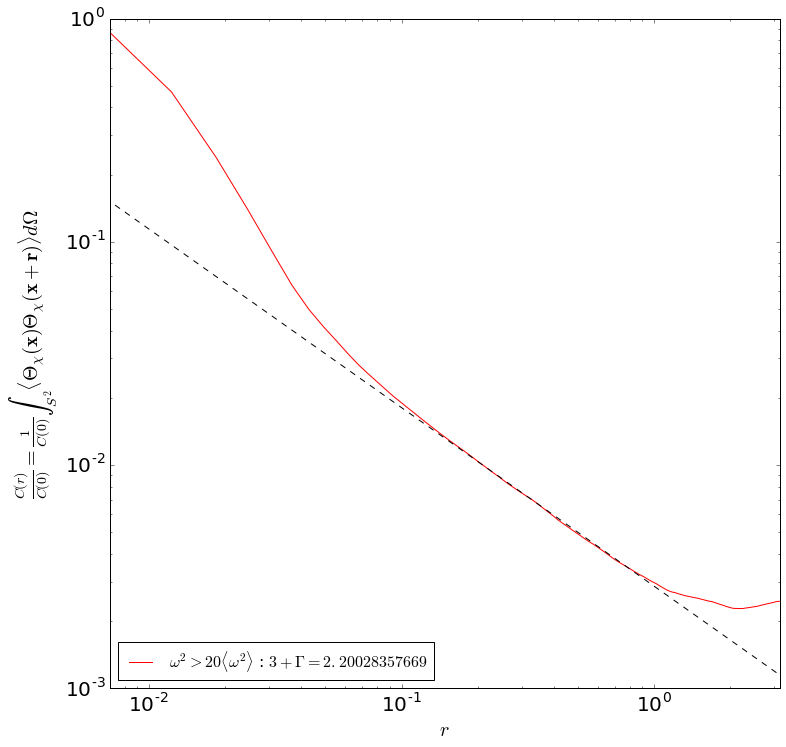

In [19]:
%%px
%matplotlib inline

t = 20

if(rank==0):
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    
    idx = r2st[0]>0
    
    rp=np.linspace(1*dx,ner*dx,ner)
    
    lrp = rp[idx]
    
    tempRp = lrp[(lrp>0.1)&(lrp<1.0)]
    plt.figure(figsize=(12,12))
    plt.xlabel(r'$r$', fontsize=20)
    plt.ylabel(r'$\frac{C(r)}{C(0)} = \frac{1}{C(0)} \int_{S^2} \langle \Theta_\chi({\bf x}) \Theta_\chi({\bf x}+{\bf r}) \rangle d\Omega$', fontsize=20)
    plt.xlim([7*10**(-3),np.pi])
    plt.ylim([10**(-3),10**0])
    #plt.grid()
    
    #for i in range(1):       
    
    corrF1 = hist[0][idx]/r2st[0][idx]
    
    tempCorrF = corrF1[(lrp>0.1)&(lrp<1.0)]
    ctmp = (corrF1[300])/(corrF1[0])
    
    fit = np.polyfit(np.log(tempRp),np.log(tempCorrF/corrF1[0]),1)
    print("t = "+str(t)+"*sigma_2: Linear fit [alpha A] = "+str(fit))
    
    plt.loglog(lrp,(corrF1)/(corrF1[0]),c,label=r'$\omega^2 > '+str(t)
                                                                  +r'\langle \omega^2\rangle$ : $3+\Gamma =' 
                                                                  +str(3+fit[0])+r'$')
    
    corrF1 = hist[0][idx]
    
    plt.loglog(lrp,np.exp(fit[1])*(lrp**(fit[0])),'k--')
    
    plt.legend(loc='lower left',prop={'size':16})
    plt.savefig('mpifft4py-twopoint-enstrophy-0.pdf')